# Data Proprocessing

In [19]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

import os, sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))
# Set max rows and columns to display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
# Read the dataset
df = pd.read_csv('../data/cleaned_data.csv', low_memory=False, index_col=False)

Understand the data

In [4]:
# Explore the first five rows
df.head(5)

,Unnamed: 0,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,MaritalStatus,Gender,Country,Province,PostalCode,MainCrestaZone,SubCrestaZone,ItemType,mmcode,VehicleType,RegistrationYear,make,Model,Cylinders,cubiccapacity,kilowatts,bodytype,NumberOfDoors,VehicleIntroDate,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,SumInsured,TermFrequency,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0,2597.0,130.0,S/D,4.0,NaN,Yes,No,119300,More than 6 months,0.01,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0,2597.0,130.0,S/D,4.0,NaN,Yes,No,119300,More than 6 months,0.01,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0,2597.0,130.0,S/D,4.0,NaN,Yes,No,119300,More than 6 months,0.01,Monthly,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0,2597.0,130.0,S/D,4.0,NaN,Yes,No,119300,More than 6 months,119300.00,Monthly,220.1628,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,54.824561,0.0
4,4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,Not specified,Not specified,South Africa,Gauteng,1459,Rand East,Rand East,Mobility - Motor,44069150.0,Passenger Vehicle,2004,MERCEDES-BENZ,E 240,6.0,2597.0,130.0,S/D,4.0,NaN,Yes,No,119300,More than 6 months,119300.00,Monthly,220.1628,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [5]:
# Check missing values in each column
missing_counts = df.isnull().sum()

# Print columns with more than 1 missing value
columns_with_missing = missing_counts[missing_counts > 1].index
print(f'Columns with more than 1 missing value:\n{columns_with_missing}')

# Drop these columns
df = df.drop(columns=columns_with_missing)

# Verify the result
print(f'Columns remaining after dropping:\n{df.columns}')

Columns with more than 1 missing value:
Index(['VehicleIntroDate'], dtype='object')
Columns remaining after dropping:
Index(['Unnamed: 0', 'UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims'],
      dtype='object')


**Identify Unique Categories:**

Check unique values for categorical features and decide on encoding strategy.

In [6]:
# Get categorical columns
categorical_columns = df.select_dtypes(include='object').columns
# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Column': categorical_columns,
    'DataType': [df[col].dtype for col in categorical_columns],
    'NumUniqueValues': [df[col].nunique() for col in categorical_columns]
})

# Print the summary DataFrame
summary_df

,Column,DataType,NumUniqueValues
0,TransactionMonth,object,23
1,Citizenship,object,4
2,LegalType,object,6
3,Title,object,5
4,Language,object,1
5,Bank,object,11
6,AccountType,object,3
7,MaritalStatus,object,3
8,Gender,object,3
9,Country,object,1


Key Insights from the Summary:

- Columns like `Language, Country, ItemType, StatutoryClass, and StatutoryRiskType` don't provide variability. 
- Drop these columns from the dataset.


- `Model` (411 unique values) could add complexity.
- Consider reducing cardinality by grouping or applying target encoding.

- Columns like AlarmImmobiliser, TrackingDevice, and NewVehicle have only 2 unique values.

- `TransactionMonth` should be converted to a date format.
- Extract useful features like year, month, and quarter if necessary.

- `CapitalOutstanding` should be numeric and can be used as a continuous feature.

In [7]:
columns_to_drop = ['Language', 'Country', 'ItemType', 'StatutoryClass', 'StatutoryRiskType']
df = df.drop(columns=columns_to_drop)


Convert the `CapitalOutstanding` to numeric format

In [8]:
# Convert 'CapitalOutstanding' to numeric, coerce errors to handle non-numeric values (e.g., empty strings or NaNs)
df['CapitalOutstanding'] = pd.to_numeric(df['CapitalOutstanding'], errors='coerce')

# Fill missing values if necessary, e.g., with 0 or the column's mean
df['CapitalOutstanding'] = df['CapitalOutstanding'].fillna(0)  # Or df['CapitalOutstanding'].fillna(df['CapitalOutstanding'].mean())

# Ensure it's a float type
df['CapitalOutstanding'] = df['CapitalOutstanding'].astype(float)

# Verify the conversion
print(df['CapitalOutstanding'].dtype)


float64


Convert boolean 'IsVATRegistered' to integer

In [9]:
# Convert boolean 'IsVATRegistered' to integer
df['IsVATRegistered'] = df['IsVATRegistered'].astype(int)

Convert the `TransactionMonth` to a datetime format and extract relevant features.

In [10]:
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])
df['TransactionYear'] = df['TransactionMonth'].dt.year
df['TransactionMonthOnly'] = df['TransactionMonth'].dt.month
df['TransactionQuarter'] = df['TransactionMonth'].dt.quarter
# Drop the original datetime column if it's no longer needed
df = df.drop(columns=['TransactionMonth'])


Check the Distribution of `Title, MaritalStatus, and Gender`

In [11]:
print(f'Gender Distribution:\n{df.Gender.value_counts()}')
print(f'Title Distribution:\n {df.Title.value_counts()}')
print(f'Marital Status Distribution:\n {df.MaritalStatus.value_counts()}')

Gender Distribution:
Gender
Not specified    950526
Male              42817
Female             6755
Name: count, dtype: int64
Title Distribution:
 Title
Mr      933555
Mrs      45850
Ms       13269
Miss      6614
Dr         810
Name: count, dtype: int64
Marital Status Distribution:
 MaritalStatus
Not specified    994467
Single             4254
Married            1377
Name: count, dtype: int64


**High Proportion of Unspecified Gender:**

A significant portion of the `Gender` values (950,526) is missing or unspecified.
- These unspecified gender values can be filled using the information from the `Title` column where available.

**Title-to-Gender Mapping:**

- Titles like `Mr, Mrs, Miss, and Ms `provide a clear indication of gender.
- Dr is ambiguous and may not specify gender directly.

**Approach to Impute Missing Genders Using Titles:**

`Mr → Male`

`Mrs, Miss, Ms → Female`

`Dr` → Leave as Not specified (since it’s ambiguous)

In [12]:
# Map Titles to Gender
title_to_gender_map = {
    'Mr': 'Male',
    'Mrs': 'Female',
    'Ms': 'Female',
    'Miss': 'Female',
    'Dr': None  # Leave as None since it could be either gender
}

# Fill missing Gender based on Title
df['Gender'] = df.apply(lambda row: title_to_gender_map.get(row['Title'], row['Gender']), axis=1)

# Display the updated Gender counts
print(df['Gender'].value_counts())


Gender
Male      933555
Female     65733
Name: count, dtype: int64


**Balanced Gender Distribution:**

The number of `male and female` entries is now significantly more balanced compared to the initial state where a large portion of the Gender values were `unspecified`.

Dropping the `MaritalStatus` column is a reasonable decision given the high proportion of unspecified values

In [13]:
# Drop the 'MaritalStatus' column from the DataFrame
df = df.drop(columns=['MaritalStatus'])


In [14]:
# Drop the specified columns from the DataFrame
df = df.drop(columns=['Unnamed: 0', 'UnderwrittenCoverID', 'PolicyID'])

**Encoding Strategy:**

- **Label Encoding:** For binary or low-cardinality features.
- **One-Hot Encoding:** For moderate cardinality features where the number of new columns remains manageable.
- **Target Encoding:** For high cardinality features to reduce the number of new features while capturing useful patterns.
- **Frequency Encoding:** Another option for high cardinality features, where you replace categories with their frequency in the dataset.

In [15]:
# Define cardinality thresholds
low_cardinality_threshold = 10
high_cardinality_threshold = 20

# Identify categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Separate features by cardinality
low_cardinality_features = [col for col in categorical_cols if df[col].nunique() <= low_cardinality_threshold]
moderate_cardinality_features = [col for col in categorical_cols if low_cardinality_threshold < df[col].nunique() <= high_cardinality_threshold]
high_cardinality_features = [col for col in categorical_cols if df[col].nunique() > high_cardinality_threshold]

# Label Encoding for low cardinality features
label_encoders = {}
for feature in low_cardinality_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# One-Hot Encoding for moderate cardinality features
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
for feature in moderate_cardinality_features:
    encoded = one_hot_encoder.fit_transform(df[[feature]])
    encoded_df = pd.DataFrame(encoded, columns=one_hot_encoder.get_feature_names_out([feature]))
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(columns=[feature])

# Frequency Encoding for high cardinality features (Example)
for feature in high_cardinality_features:
    freq = df[feature].value_counts()
    df[feature + '_freq'] = df[feature].map(freq)
    df = df.drop(columns=[feature])



# Save or proceed with further analysis/modeling
# df.to_csv('preprocessed_data.csv', index=False)  # Uncomment to save the preprocessed data


In [16]:
# Verify the transformations
df.head()


,IsVATRegistered,Citizenship,LegalType,Title,AccountType,Gender,Province,PostalCode,mmcode,VehicleType,RegistrationYear,Cylinders,cubiccapacity,kilowatts,NumberOfDoors,AlarmImmobiliser,TrackingDevice,CapitalOutstanding,NewVehicle,SumInsured,TermFrequency,CalculatedPremiumPerTerm,Section,Product,TotalPremium,TotalClaims,TransactionYear,TransactionMonthOnly,TransactionQuarter,Bank_Capitec Bank,Bank_First National Bank,Bank_FirstRand Bank,Bank_Investec Bank,Bank_Ithala Bank,Bank_Mercantile Lisbon Bank,Bank_Nedbank,Bank_Old Mutual,Bank_RMB Private Bank,Bank_Standard Bank,MainCrestaZone_Cape Province (Cape Town),MainCrestaZone_Cape Province (East and North of Cape Town),"MainCrestaZone_Ciskei, Cape Mid 1",MainCrestaZone_East London,MainCrestaZone_Johannesburg,MainCrestaZone_Karoo 1 (Northeast of Cape Town),"MainCrestaZone_Langkloof, Coast 2, Coast 1",MainCrestaZone_Natal,MainCrestaZone_Natal (Durban),MainCrestaZone_Oranje Free State,MainCrestaZone_Port Elizabeth,MainCrestaZone_Rand East,"MainCrestaZone_Tembu 2, Cape Mid 2, Cape Mid West, Tembu 1",MainCrestaZone_Transvaal (Pretoria),MainCrestaZone_Transvaal (all except Pretoria),bodytype_C/C,bodytype_C/P,bodytype_CCL,bodytype_D/C,bodytype_D/S,bodytype_H/B,bodytype_MPV,bodytype_P/V,bodytype_S/C,bodytype_S/D,bodytype_S/W,bodytype_SUV,ExcessSelected_Mobility - Metered Taxis - R2000,ExcessSelected_Mobility - Metered Taxis - R5000,ExcessSelected_Mobility - R250,ExcessSelected_Mobility - Taxi with value less than R100 000 - R3 000,ExcessSelected_Mobility - Taxi with value more than R100 000 - R10 000,ExcessSelected_Mobility - Taxi with value more than R100 000 - R5 000,ExcessSelected_Mobility - Taxi with value more than R100 000 - R5 000 (April),ExcessSelected_Mobility - Taxi with value more than R100 000 - R7 500,ExcessSelected_Mobility - Trailers,ExcessSelected_Mobility - Windscreen,ExcessSelected_Mobility - Windscreen (Feb2015),ExcessSelected_No excess,CoverGroup_Asset Value Preserver,CoverGroup_Baggage/Luggage,CoverGroup_Basic Excess Waiver,CoverGroup_Cash Takings,CoverGroup_Comprehensive - Taxi,CoverGroup_Credit Protection,CoverGroup_Deposit Cover,"CoverGroup_Fire,Theft and Third Party",CoverGroup_Income Protector,CoverGroup_Motor Comprehensive,CoverGroup_Standalone passenger liability,CoverGroup_Third Party Only,CoverGroup_Trailer,SubCrestaZone_freq,make_freq,Model_freq,CoverCategory_freq,CoverType_freq
0,1,0,0,2,0,1,2,1459,44069150.0,4,2004,6.0,2597.0,130.0,4.0,1,0,119300.0,1,0.01,1,25.0000,1,2,21.929825,0.0,2015,3,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42168,41940,180,97313,103763
1,1,0,0,2,0,1,2,1459,44069150.0,4,2004,6.0,2597.0,130.0,4.0,1,0,119300.0,1,0.01,1,25.0000,1,2,21.929825,0.0,2015,5,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42168,41940,180,97313,103763
2,1,0,0,2,0,1,2,1459,44069150.0,4,2004,6.0,2597.0,130.0,4.0,1,0,119300.0,1,0.01,1,25.0000,1,2,0.000000,0.0,2015,7,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42168,41940,180,97313,103763
3,1,0,0,2,0,1,2,1459,44069150.0,4,2004,6.0,2597.0,130.0,4.0,1,0,119300.0,1,119300.00,1,220.1628,1,2,54.824561,0.0,2015,5,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42168,41940,180,8776,104183
4,1,0,0,2,0,1,2,1459,44069150.

Create new feature from TotalPremium and TotalClaims

In [17]:
df['Premium_to_Claims_Ratio'] = df['TotalPremium'] / (df['TotalClaims'] + 1)  # +1 to avoid division by zero

**Scaling Before Feature Selection :**

Feature scaling should typically be performed before feature selection. This ensures that all features are on a comparable scale before we apply selection techniques like SelectKBest, which may rely on statistical methods sensitive to scale, such as `f_classif` or `mutual_info_classif`.

If features have different ranges, features with larger scales might dominate the selection process, making the selection biased toward those features. By scaling before selection, each feature contributes fairly to the selection criteria.

In [20]:
# Separate Target and Feature Variables
X = df.drop(columns=['TotalPremium', 'TotalClaims'])
y = df['TotalPremium']  # or 'TotalClaims' depending on the target

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Feature Selection and Dimensionality Reduction**

In [28]:
#  Feature Selection using SelectKBest

selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_new = selector.fit_transform(X_scaled, y)

Reduce Dimensionality
In large datasets with many features, some features might be redundant or highly correlated. PCA transforms these features into a smaller set of uncorrelated variables called principal components, which capture most of the variability in the data.
This can lead to simpler, faster models that are less prone to overfitting.

In [ ]:
# Example: Dimensionality Reduction using PCA
pca = PCA(n_components=20)  # Reduce to 20 principal components
X_pca = pca.fit_transform(X)

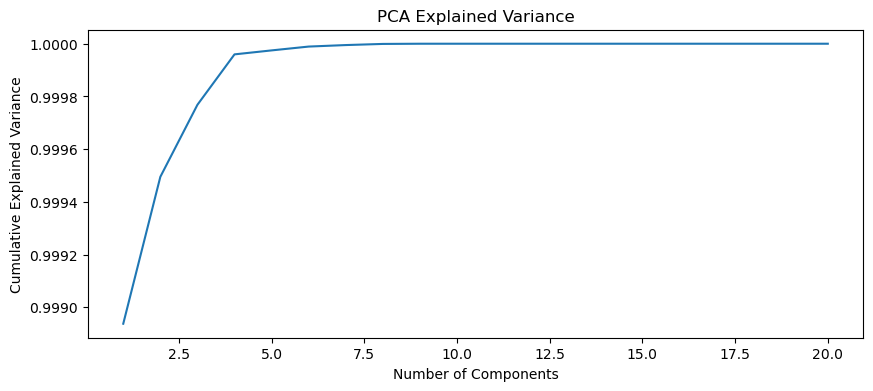

In [21]:
# Plot explained variance
plt.figure(figsize=(10, 4))
sns.lineplot(x=range(1, 21), y=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [29]:
# Get the names of the selected features
selected_features = X.columns[selector.get_support()]
# Create a dataframe with the selected features and their corresponding PCA Componets
#df_result = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(20)])
# df_result['Selected_Features'] = selected_features

In [33]:
# Create new dataframe with selected features
df_new = pd.DataFrame(X_new, columns=selected_features)
# merge the target variable to the new dataframe
df_new['TotalPremium'] = y

In [39]:
# Save the new dataframe to csv for model training
df_new.to_csv('../data/preprocessed_data.csv', index=False)

In [40]:
df_new.head()

,IsVATRegistered,RegistrationYear,CalculatedPremiumPerTerm,Product,Bank_Investec Bank,Bank_Mercantile Lisbon Bank,MainCrestaZone_Natal (Durban),bodytype_C/P,bodytype_MPV,bodytype_S/D,ExcessSelected_Mobility - R250,ExcessSelected_Mobility - Trailers,ExcessSelected_Mobility - Windscreen,ExcessSelected_No excess,CoverGroup_Baggage/Luggage,CoverGroup_Cash Takings,CoverGroup_Comprehensive - Taxi,CoverGroup_Trailer,CoverCategory_freq,CoverType_freq,TotalPremium
0,14.074932,-1.908809,-0.460139,3.248695,-0.027064,-0.011619,-0.300558,-0.025384,-0.187147,4.784029,-0.021521,-0.008718,3.045838,-1.946355,-0.013115,-0.01706,0.462091,-0.008718,0.374133,0.459047,21.929825
1,14.074932,-1.908809,-0.460139,3.248695,-0.027064,-0.011619,-0.300558,-0.025384,-0.187147,4.784029,-0.021521,-0.008718,3.045838,-1.946355,-0.013115,-0.01706,0.462091,-0.008718,0.374133,0.459047,21.929825
2,14.074932,-1.908809,-0.460139,3.248695,-0.027064,-0.011619,-0.300558,-0.025384,-0.187147,4.784029,-0.021521,-0.008718,3.045838,-1.946355,-0.013115,-0.01706,0.462091,-0.008718,0.374133,0.459047,0.000000
3,14.074932,-1.908809,1.888399,3.248695,-0.027064,-0.011619,-0.300558,-0.025384,-0.187147,4.784029,-0.021521,-0.008718,-0.328317,-1.946355,-0.013115,-0.01706,0.462091,-0.008718,-2.852745,0.478056,54.824561
4,14.074932,-1.908809,1.888399,3.248695,-0.027064,-0.011619,-0.300558,-0.025384,-0.187147,4.784029,-0.021521,-0.008718,-0.328317,-1.946355,-0.013115,-0.01706,0.462091,-0.008718,-2.852745,0.478056,0.000000


In [41]:
df_new.mean()

IsVATRegistered                        -1.965169e-17
RegistrationYear                       -1.841734e-14
CalculatedPremiumPerTerm               -2.069466e-16
Product                                -3.034004e-16
Bank_Investec Bank                      1.331427e-17
Bank_Mercantile Lisbon Bank             1.893411e-18
MainCrestaZone_Natal (Durban)           6.968320e-17
bodytype_C/P                           -8.326745e-18
bodytype_MPV                            2.907256e-17
bodytype_S/D                           -5.297288e-17
ExcessSelected_Mobility - R250         -2.589674e-18
ExcessSelected_Mobility - Trailers     -2.229109e-19
ExcessSelected_Mobility - Windscreen    4.527135e-17
ExcessSelected_No excess               -1.165176e-17
CoverGroup_Baggage/Luggage             -3.829450e-18
CoverGroup_Cash Takings                -2.058596e-17
CoverGroup_Comprehensive - Taxi        -1.182227e-16
CoverGroup_Trailer                     -2.229109e-19
CoverCategory_freq                      5.7747

In [42]:
df_new.std()

IsVATRegistered                          1.000000
RegistrationYear                         1.000000
CalculatedPremiumPerTerm                 1.000000
Product                                  1.000000
Bank_Investec Bank                       1.000000
Bank_Mercantile Lisbon Bank              1.000000
MainCrestaZone_Natal (Durban)            1.000000
bodytype_C/P                             1.000000
bodytype_MPV                             1.000000
bodytype_S/D                             1.000000
ExcessSelected_Mobility - R250           1.000000
ExcessSelected_Mobility - Trailers       1.000000
ExcessSelected_Mobility - Windscreen     1.000000
ExcessSelected_No excess                 1.000000
CoverGroup_Baggage/Luggage               1.000000
CoverGroup_Cash Takings                  1.000000
CoverGroup_Comprehensive - Taxi          1.000000
CoverGroup_Trailer                       1.000000
CoverCategory_freq                       1.000000
CoverType_freq                           1.000000
